In [149]:
import sys
import collections
import numpy as np
from scipy.stats import norm, expon, erlang, gamma

%matplotlib inline
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt

sys.path.append('..')
from higgs_inference.various.utils import r_from_s, s_from_r, format_number

# Toy model

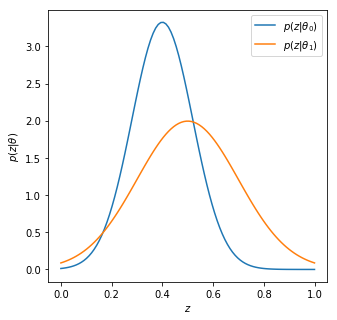

In [66]:
p_z_theta0 = norm(loc=0.4,scale=0.12)
p_z_theta1 = norm(loc=0.5,scale=0.2)

plt.figure(figsize=(5,5))
z = np.linspace(0.,1.,100)
plt.plot(z, p_z_theta0.pdf(z), label=r'$p(z | \theta_0)$')
plt.plot(z, p_z_theta1.pdf(z), label=r'$p(z | \theta_1)$')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$p(z | \theta)$')
plt.show()

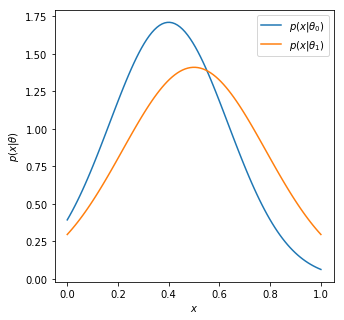

In [67]:
def p_x_z(z):
    return norm(loc=z, scale=0.2)

p_x_theta0 = norm(loc=0.4,scale=(0.12**2 + 0.2**2)**0.5)
p_x_theta1 = norm(loc=0.5,scale=(0.2**2 + 0.2**2)**0.5)

plt.figure(figsize=(5,5))
x = np.linspace(0.,1.,100)
plt.plot(x, p_x_theta0.pdf(x), label=r'$p(x | \theta_0)$')
plt.plot(x, p_x_theta1.pdf(x), label=r'$p(x | \theta_1)$')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x | \theta)$')
plt.show()

In [112]:
def p_xz(x,z):
    return 0.5 * (p_z_theta0.pdf(z) + p_z_theta1.pdf(z)) * p_x_z(z).pdf(x)

def p_z_x(z,x):
    num = p_x_z(z).pdf(x) * 0.5 * (p_z_theta0.pdf(z) + p_z_theta0.pdf(z))
    den = 0.5 * (p_x_theta0.pdf(x) + p_x_theta1.pdf(x))
    return num / den

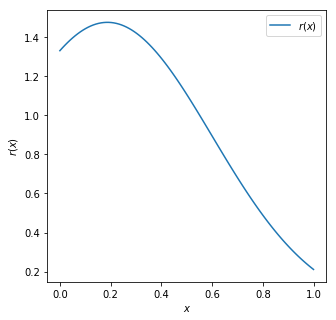

In [82]:
def r_x(x):
    return p_x_theta0.pdf(x) / p_x_theta1.pdf(x)

def r_xz(x,z):
    return (p_z_theta0.pdf(z) * p_x_z(z).pdf(x)) / (p_z_theta1.pdf(z) * p_x_z(z).pdf(x))

plt.figure(figsize=(5,5))
x = np.linspace(0.,1.,100)
plt.plot(x, r_x(x), label=r'$r(x)$')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$r(x)$')
plt.show()

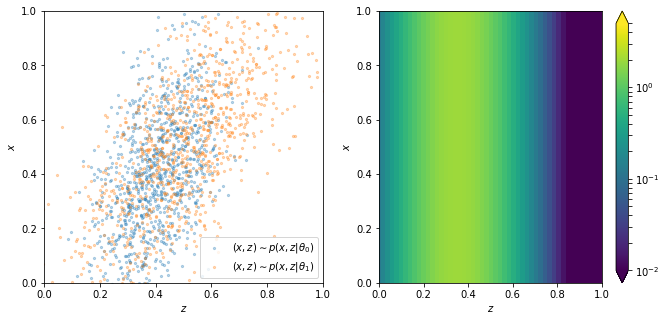

In [70]:
z_from_theta0 = p_z_theta0.rvs(1000)
x_from_theta0 = p_x_z(z_from_theta0).rvs(1000)

z_from_theta1 = p_z_theta1.rvs(1000)
x_from_theta1 = p_x_z(z_from_theta1).rvs(1000)

fig = plt.figure(figsize=(11,5))

ax = plt.subplot(1,2,1)
plt.scatter(z_from_theta0, x_from_theta0, alpha=0.3, s=5, label=r'$(x,z) \sim p(x, z | \theta_0)$')
plt.scatter(z_from_theta1, x_from_theta1, alpha=0.3, s=5, label=r'$(x,z) \sim p(x, z | \theta_1)$')
plt.legend(loc='lower right')
plt.xlim(0.,1.)
plt.ylim(0.,1.)
plt.xlabel(r'$z$')
plt.ylabel(r'$x$')

ax = plt.subplot(1,2,2)
xi = np.linspace(-1.0, 1.0, 100)
zi = np.linspace(-1.0, 1.0, 100)
zz, xx = np.meshgrid(xi, zi)
pcm = ax.pcolormesh(zi, xi, r_xz(xx, zz).reshape((100, 100)),
                   norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=5.),
                   cmap='viridis')
cbar = fig.colorbar(pcm, ax=ax, extend='both')
plt.xlim(0.,1.)
plt.ylim(0.,1.)
plt.xlabel(r'$z$')
plt.ylabel(r'$x$')

plt.show()

# Loss functions

In [142]:
def mse(r, x, zmin=-10., zmax=11., zsteps=2100):
    z_integration = np.linspace(zmin, zmax, zsteps)
    dz_integration = (zmax - zmin) / zsteps
    p_integrands = p_z_theta1.pdf(z_integration) * p_x_z(z_integration).pdf(x)
    mse_integrands = (r - r_xz(x, z_integration))**2
    
    integrands = (
        dz_integration
        * p_integrands
        * mse_integrands
    )
    
    mse = np.sum(integrands[np.isfinite(integrands)])
    
    return mse
    

In [143]:
def xe(r, x, zmin=-10., zmax=11., zsteps=2100):
    s_hat_x = s_from_r(r)
    
    z_integration = np.linspace(zmin, zmax, zsteps)
    dz_integration = (zmax - zmin) / zsteps
    p_integrands = p_xz(x,z_integration)
    
    r_xz_integrands = r_xz(x, z_integration)
    s_xz_integrands = s_from_r(r_xz_integrands)
    xe_integrands = s_xz_integrands * np.log(s_hat_x) + (1. - s_xz_integrands) * np.log(1. - s_hat_x)
    
    integrands = (
        dz_integration
        * p_integrands
        * xe_integrands
    )
    
    xe = - np.sum(integrands[np.isfinite(integrands)])
    
    return xe
    

In [153]:
def make_plot(x):
    r_test = np.linspace(0.01,4.,100)
    mse_test = np.array([mse(r_, x) for r_ in r_test])
    xe_test = np.array([xe(r_, x) for r_ in r_test])

    r_true = r_x(x)
    rhat_mse = r_test[np.argmin(mse_test)]
    rhat_xe = r_test[np.argmin(xe_test)]

    fig = plt.figure(figsize=(5,5))

    plt.plot(r_test, mse_test, c='C0', label=r'$MSE[\hat{r}(x)]$')
    plt.plot(r_test, xe_test, c='C1', label=r'$XE[\hat{r}(x)]$')

    plt.axvline(r_x(x), c='black', ls='--', label=r'$r(x) = ' + format_number(r_true,2) + '$')
    plt.axvline(rhat_mse, c='C0', alpha=0.5, ls=':', label=r'$\hat{r}_{MSE}(x) = ' + format_number(rhat_mse,2) + '$')
    plt.axvline(rhat_xe, c='C1', alpha=0.5, ls=':', label=r'$\hat{r}_{XE}(x) = ' + format_number(rhat_xe,2) + '$')

    plt.legend(loc='lower right')
    plt.xlim(0.,5.)
    plt.ylabel(r'Loss')
    plt.xlabel(r'$\hat{r}(x)$')

    plt.show()

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


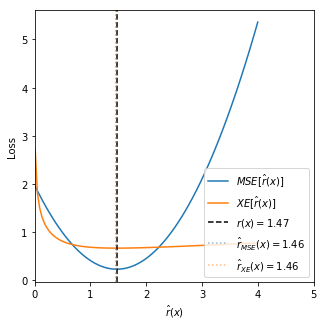

In [154]:
make_plot(0.2)